In [190]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

X, y = make_friedman1(n_samples=1200, random_state=0, noise=1.0)
x_train, x_test = X[:200], X[200:300]
y_train, y_test = y[:200], y[200:300]

y_train = y_train.reshape((200, 1))
data = np.concatenate([x_train, y_train], axis=1)

y_test = y_test.reshape((x_test.shape[0], 1))
testdata = np.concatenate([x_test, y_test], axis=1)
data[:2]

array([[ 0.5488135 ,  0.71518937,  0.60276338,  0.54488318,  0.4236548 ,
         0.64589411,  0.43758721,  0.891773  ,  0.96366276,  0.38344152,
        18.40631483],
       [ 0.79172504,  0.52889492,  0.56804456,  0.92559664,  0.07103606,
         0.0871293 ,  0.0202184 ,  0.83261985,  0.77815675,  0.87001215,
        19.60677754]])

In [217]:
class treeNode:
    def __init__(self, label_class=None, feature=None, value=None, right_tree=None, left_tree=None):
        self.feature = feature
        self.value = value
        self.right_tree = right_tree
        self.left_tree = left_tree
        self.label_class = label_class
        
    def __name__(self):
        return "treenode"
    
    
class Tree:
    def __init__(self, min_leafs=5, max_depth=10):
        self.min_leafs = min_leafs
        self.max_depth = max_depth
        
    def binsplitdata(self, data, feature, value):
        mat0 = data[data[:, feature] > value, : ]
        mat1 = data[data[:, feature] <= value, : ]
        return mat0, mat1
    
    # 利用字典的方式创建一棵树。
    """
    def createTree_old(self, data, leafType=regleaf, errType=regerr, ops=(1,4)):
        # 这里阐释了如何 利用递归的思想去 建立决策树
        feat, val = self.choosebestsplit(data, leafType, errType, ops)
        # 如果没有可以再次切分的  feature 就返回val
        if feat == None:
            return val
        # 这里注意创建了一个新的 字典？
        retTree = {}
        retTree['spInd'] = feat
        retTree['spVal'] = val
        lSet,rSet = self.binsplitdata(data,feat,val)
        retTree['left'] = self.createTree_old(lSet,leafType,errType, ops)
        retTree['right'] = self.createTree_old(rSet,leafType,errType, ops)
        return retTree
    """
    
    @classmethod
    def get_deep(cls, model):
        max_deep = 0
        if model.right_tree is not None:
            temp_deep = 1 + cls.get_deep(model.right_tree)
            if temp_deep > max_deep:
                max_deep = temp_deep
        if model.left_tree is not None:
            temp_deep = 1 + cls.get_deep(model.left_tree)
            if temp_deep > max_deep:
                max_deep = temp_deep
        return max_deep

    @classmethod
    def print_leafs(cls, model):
        if model.label_class is not None:
            print("leaf value is {}".format(model.label_class))
        if model.left_tree is not None:
            cls.print_leafs(model.left_tree)
        if model.right_tree is not None:
            cls.print_leafs(model.right_tree)
            
    @classmethod
    def predict_line(cls, model, line):
        if model.label_class is not None:
            return model.label_class
        split_feature = model.feature
        split_value = model.value
        if line[split_feature] > split_value:
            return cls.predict_line(model.right_tree, line)
        else:
            return cls.predict_line(model.left_tree, line)
        
    @classmethod
    def predict(cls, model, data):
        myre = []
        for line in data:
            te = cls.predict_line(model, line)
            myre.append(te)
        myre = np.array(myre).reshape(len(data), 1)
        return myre

In [218]:
class cartreeregression(Tree):
    def __init__(self, min_leafs=4):
        super(cartreeregression, self).__init__()
        self.min_leafs = min_leafs
        
    def regleaf(self, data):
        return np.mean(data[:,-1])
    
    def regerr(self, data):
        return np.var(data[:, -1]) 
    
    def createTree(self, data):
        retTree = treeNode()
        # 可以添加其他条件,终止树 停止生长，分类和回归树有不同的搞法。
        # 这里阐释了如何 利用递归的思想去 建立决策树
        feat, val = self.choosebestsplit(data)
        # 如果没有可以再次切分的  feature 就返回val
        if feat is None:
            retTree.label_class = self.regleaf(data)
            return retTree
        
        retTree.feature = feat
        retTree.value = val
        lSet, rSet = self.binsplitdata(data, feat, val)
        retTree.left_tree = self.createTree(lSet)
        retTree.right_tree = self.createTree(rSet)
        return retTree
    
    def choosebestsplit(self, data):
        data = np.array(data)
        m, n = data.shape
    
    
        # 计算初始的方差。
        S = self.regerr(data)
        best_s = np.inf
        best_feat = None 
        best_val = None
    
        for i in range(n-1): # n-1 feature
            for j in np.unique(data[:, i]):
                mat0, mat1 = self.binsplitdata(data, i, j)
                # 控制叶子的数量。不进行控制 进行充分的生长
                if (np.shape(mat0)[0] < self.min_leafs) or (np.shape(mat1)[0] < self.min_leafs):
                    continue
                new_s = self.regerr(mat0) + self.regerr(mat1)
                if new_s < best_s: 
                    best_feat = i
                    best_val = j
                    best_s = new_s
                #if S - best_s < 0.01:这个地方需要再思考下
                    #return best_feat, best_val
        return best_feat, best_val

In [219]:
def getMean(tree, i=0, flag=False):
    """
    如果 树的两个分支都不是树的话，求均值就可以了。 value 为none时 label_class一定不为none, 否则已经结束
    """
    if tree.right_tree.value is not None:
        tree.right_tree.label_class = getMean(tree.right_tree, i=i+1)
    if tree.left_tree.value is not None:
        tree.left_tree.label_class = getMean(tree.left_tree, i=i+1)
    means = (tree.right_tree.label_class + tree.left_tree.label_class) / 2.0
    print("level is {} and value is {}".format(i, means))
    return means

In [220]:
def binsplitdata(data, feature, value):
    mat0 = data[data[:, feature] > value, : ]
    mat1 = data[data[:, feature] <= value, : ]
    return mat0, mat1

In [221]:
def myprune(tree, testData, min_leafs=10, diff_err=10):
    if np.shape(testData)[0] < min_leafs:
        # 这里是有一定的合理性的
        tree.label_class = getMean(tree)
        tree.right_tree = None
        tree.left_tree = None
        tree.value = None
        tree.feature = None
        return tree
    
    if tree.feature is not None:
        lSet, rSet = binsplitdata(testData, tree.feature, tree.value)
        
    if tree.left_tree.label_class is None and tree.left_tree.value is not None: # and lSet.shape[0] > min_leafs:
        tree.left_tree = myprune(tree.left_tree, lSet)
        
    if tree.right_tree.label_class is None and tree.right_tree.value is not None:# and rSet.shape[0] > min_leafs:
        tree.right_tree = myprune(tree.right_tree, rSet)
        
    #if tree.left_tree is not None and not tree.right_tree is not None and tree.left_tree.label_class is not None and tree.right_tree.label_class is not None:
    if tree.left_tree.label_class is not None and tree.right_tree.label_class is not None:
        lSet, rSet = binsplitdata(testData, tree.feature, tree.value)
        errorNoMerge = sum(np.power(lSet[:,-1] - tree.left_tree.label_class,2)) + sum(np.power(rSet[:,-1] - tree.right_tree.label_class, 2.0))
        
        # 这里注意 有点意思
        #treeMean = (tree['left'] + tree['right']) / 2.0
        treeMean = (tree.left_tree.label_class + tree.right_tree.label_class) / 2.0
        
        # 合并之后的 的 方差
        errorMerge = sum(np.power(testData[:,-1] - treeMean, 2))
        m, n = testData.shape
        print("errormerge {}, errornomerge {} m is {} ---".format(errorMerge / m, errorNoMerge/m, m))
        print((errorMerge - errorNoMerge) / m, "means")
        if (errorMerge - errorNoMerge) / m < diff_err:
        #if errorMerge < errorNoMerge:
            print("merging")
            tree.label_class = treeMean
            tree.right_tree = None
            tree.left_tree = None
            tree.value = None
            tree.feature = None
            return tree
        else:
            return tree
    else:
        return tree

In [222]:
mymodel = cartreeregression(min_leafs=3)
result = mymodel.createTree(data)
print(get_deep(result))
sx = myprune(result, testdata, min_leafs=50, diff_err=2)

28
level is 1 and value is 25.709386021612325
level is 1 and value is 20.80591948217272
level is 0 and value is 23.257652751892522
level is 2 and value is 20.221109115918708
level is 1 and value is 18.992399305288814
level is 0 and value is 16.4784844509121
errormerge 17.122145973675455, errornomerge 22.903938705279433 m is 12 ---
-5.7817927316039786 means
merging
errormerge 29.989426201098308, errornomerge 17.122145973675455 m is 12 ---
12.867280227422851 means
level is 2 and value is 11.648435573537048
level is 1 and value is 13.936585063628122
level is 0 and value is 15.982687175850796
level is 0 and value is 16.854483454725486
level is 0 and value is 13.849750309495343
errormerge 15.231256127905898, errornomerge 9.491255638130372 m is 10 ---
5.7400004897755235 means
merging
errormerge 18.81743429892902, errornomerge 16.49288261068627 m is 12 ---
2.3245516882427495 means
merging
errormerge 18.969043834889288, errornomerge 18.81743429892902 m is 12 ---
0.15160953596026872 means
mergi

In [223]:
sx = myprune(result, testdata, min_leafs=10, diff_err=10)
get_deep(sx)

errormerge 29.989426201098308, errornomerge 17.122145973675455 m is 12 ---
12.867280227422851 means
errormerge 44.27292295456994, errornomerge 30.461478047380062 m is 28 ---
13.811444907189882 means


24

In [224]:
pred_test = mymodel.predict(sx, testdata[:, :-1])

In [225]:
import matplotlib.pyplot as plt
%matplotlib inline

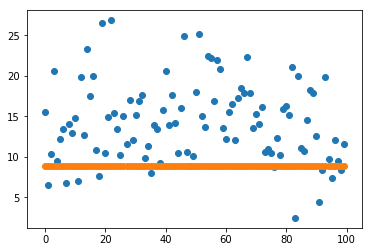

In [226]:
plt.scatter(np.arange(len(testdata)), testdata[:, -1])
plt.scatter(np.arange(len(testdata)), pred_test)